In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 4

In [2]:
from AJ_ML_Library import models_classification

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
train = pd.read_csv('data/train_modified_5.csv')
test = pd.read_csv('data/test_modified_5.csv')

In [5]:
train.shape, test.shape

((7381, 187), (11171, 186))

In [6]:
train.columns

Index([u'fault_severity', u'id', u'location', u'event_type 10',
       u'event_type 11', u'event_type 13', u'event_type 14', u'event_type 15',
       u'event_type 18', u'event_type 2',
       ...
       u'resource_type 7', u'resource_type 8', u'resource_type 9',
       u'severity_type 1', u'severity_type 2', u'severity_type 3',
       u'severity_type 4', u'severity_type 5', u'location_count',
       u'feature_count'],
      dtype='object', length=187)

In [7]:
train['fault_severity'].value_counts()

0    4784
1    1871
2     726
Name: fault_severity, dtype: int64

In [8]:
target = 'fault_severity'
IDcol = 'id'
output_colnames = ['predict_0','predict_1','predict_2']

In [9]:
#Combine the data first:
train['source'] = 'train'
test['source'] = 'test'
data = pd.concat([train,test], ignore_index=True)
data.shape

(18552, 188)

## Create New Features

In [10]:
feat_pred = [x for x in data.columns if x.startswith('feature ')]
len(feat_pred)

131

In [11]:
#create log features:
for f in feat_pred:
    data[f] = data[f].apply(lambda x: np.log(x+1))

In [12]:
sum(data['location_count']<2)

169

In [13]:
def create_location_count(features):
    for feat in features:
        loc_count = data.pivot_table(values=feat, index='location',aggfunc=lambda x: sum(x>0))
        data['loc_count_%s'%feat] = data['location'].apply(lambda x: loc_count[x])
        
def create_location_stats(features):
    for feat in features:
        loc_mean = data.pivot_table(values=feat, index='location',aggfunc=lambda x: np.mean([i for i in x if i>0]) if sum(x>0)>0 else 0)
        data['loc_mean_%s'%feat] = data['location'].apply(lambda x: loc_mean[x])

In [14]:
new_feat = ['feature 203','feature 82','event_type 11','severity_type 1','feature 170','feature 54',
            'feature 201','feature 80','feature 71','feature 193','feature 54','feature 312','feature 202',
            'feature others_1','feature 232','feature 68', 'feature others_0','feature 307']
create_location_count(new_feat)

In [15]:
new_feat = ['feature 203','feature 82','feature 170','feature 54',
            'feature 201','feature 80','feature 71','feature 193','feature 54','feature 312','feature 202',
            'feature others_1','feature 232','feature 68', 'feature others_0','feature 307']
create_location_stats(new_feat)

In [16]:
print data[[u'loc_mean_feature 80', u'loc_mean_feature 71', u'loc_mean_feature 193',
       u'loc_mean_feature 312']].head()

   loc_mean_feature 80  loc_mean_feature 71  loc_mean_feature 193  \
0             0.000000                    0                     0   
1             0.000000                    0                     0   
2             0.000000                    0                     0   
3             1.585072                    0                     0   
4             0.000000                    0                     0   

   loc_mean_feature 312  
0              2.750371  
1              1.711339  
2              0.881157  
3              0.000000  
4              0.751071  


In [17]:
data[[u'loc_count_feature 203', u'loc_count_feature 82',
       u'loc_count_event_type 11', u'loc_count_severity_type 1',
       u'loc_count_feature 170', u'loc_count_feature 54']].head()

,loc_count_feature 203,loc_count_feature 82,loc_count_event_type 11,loc_count_severity_type 1,loc_count_feature 170,loc_count_feature 54
0,0,0,3,11,0,0
1,0,0,0,3,0,0
2,0,0,0,1,0,0
3,42,49,43,44,0,0
4,0,0,2,4,0,0


In [18]:
# data['location2'] = data['location'].values
# data['location2'].loc[data['location_count']==1] = -10

In [19]:
data = data.sort_values('id')

## Create Patterns

In [20]:
le = LabelEncoder()

### 1. Pattern based on features

In [21]:
data['pattern_feature'] = data[feat_pred].apply(lambda x: ''.join(map(str,x.values)),axis=1) 

In [22]:
data['pattern_feature'] = le.fit_transform(data['pattern_feature'])

In [23]:
pattern_feature_count = data['pattern_feature'].value_counts()
data['pattern_feature_count'] = data['pattern_feature'].apply(lambda x: pattern_feature_count[x])

In [24]:
len(data['pattern_feature'].unique())

9581

In [25]:
sum(data['pattern_feature'].value_counts()>5)

380

In [26]:
# data['pattern_feature'].loc[data['pattern_feature_count']<=3] = -10

### 2. Pattern based on features+severitytype+event+resource

In [27]:
severity_pred = [x for x in data.columns if x.startswith('severity_type ')]
event_pred = [x for x in data.columns if x.startswith('event_type ')]
resource_pred = [x for x in data.columns if x.startswith('resource_type ')]
fser_pred = feat_pred+severity_pred+resource_pred
len(fser_pred)

146

In [28]:
print severity_pred
print event_pred
print resource_pred

['severity_type 1', 'severity_type 2', 'severity_type 3', 'severity_type 4', 'severity_type 5']
['event_type 10', 'event_type 11', 'event_type 13', 'event_type 14', 'event_type 15', 'event_type 18', 'event_type 2', 'event_type 20', 'event_type 21', 'event_type 22', 'event_type 23', 'event_type 24', 'event_type 26', 'event_type 27', 'event_type 28', 'event_type 29', 'event_type 30', 'event_type 32', 'event_type 34', 'event_type 35', 'event_type 40', 'event_type 42', 'event_type 43', 'event_type 44', 'event_type 45', 'event_type 46', 'event_type 47', 'event_type 5', 'event_type 50', 'event_type 54', 'event_type 6', 'event_type 7', 'event_type 8', 'event_type others_0', 'event_type others_1', 'event_type others_2']
['resource_type 1', 'resource_type 10', 'resource_type 2', 'resource_type 3', 'resource_type 4', 'resource_type 5', 'resource_type 6', 'resource_type 7', 'resource_type 8', 'resource_type 9']


In [29]:
data['pattern_event'] = data[event_pred].apply(lambda x: ''.join(map(str,x.values)),axis=1) 
data['pattern_event'] = le.fit_transform(data['pattern_event'])
pattern_event_count = data['pattern_event'].value_counts()
data['pattern_event_count'] = data['pattern_event'].apply(lambda x: pattern_event_count[x])

In [30]:
# print len(data['pattern_event'].unique())
# print sum(data['pattern_event'].value_counts()>5)
# data['pattern_event'].loc[data['pattern_event_count']<=3] = -10

In [31]:
data['pattern_resource'] = data[resource_pred].apply(lambda x: ''.join(map(str,x.values)),axis=1) 
data['pattern_resource'] = le.fit_transform(data['pattern_resource'])
pattern_resource_count = data['pattern_resource'].value_counts()
data['pattern_resource_count'] = data['pattern_resource'].apply(lambda x: pattern_resource_count[x])

In [32]:
# print len(data['pattern_resource'].unique())
# print sum(data['pattern_resource'].value_counts()>5)
# data['pattern_resource'].loc[data['pattern_resource_count']<=3] = -10

In [33]:
data['pattern_all'] = data[fser_pred].apply(lambda x: ''.join(map(str,x.values)),axis=1) 
data['pattern_all'] = le.fit_transform(data['pattern_all'])
pattern_all_count = data['pattern_all'].value_counts()
data['pattern_all_count'] = data['pattern_all'].apply(lambda x: pattern_all_count[x])

In [34]:
# print len(data['pattern_all'].unique())
# print sum(data['pattern_all'].value_counts()>5)
# data['pattern_all'].loc[data['pattern_all_count']<=3] = -10

In [35]:
data['resource_count'] = data[resource_pred].apply(np.sum, axis=1)
data['event_count'] = data[event_pred].apply(np.sum, axis=1)

### 3. Sequencial Pattern on different variables:

In [36]:
# def create_sequential_pattern(feature, nseq):
#     #create lag vars:
#     for i in range(1,nseq+1):
#         data['lag_feature_%d'%i] = data[feature].shift(nseq+1-i).fillna(-1)
#     lag_pred = ['lag_feature_%d'%i for i in range(1,nseq+1)]
#     for i in range(2,nseq+1):    
#         colname = 'sequence%d_%s'%(i,feature)
#         data[colname] = data[lag_pred[-i:]].apply(lambda x: ''.join(map(str,x.astype(int).values)),axis=1) 
#         data[colname] = le.fit_transform(data[colname])
#         colname_count = data[colname].value_counts()
#         data['%s_count'%colname] = data[colname].apply(lambda x: colname_count[x])
#         data[colname].iloc[:i] = -1
#         data['%s_count'%colname].iloc[:i] = -1
#     data.drop(lag_pred, axis=1,inplace=True)

def create_sequential_counts(feature, nseq):
    #create lag vars:
    for i in range(1,nseq+1):
        data['lag_feature_%d'%i] = data[feature].shift(nseq+1-i).fillna(0)
    lag_pred = ['lag_feature_%d'%i for i in range(1,nseq+1)]
    for i in range(2,nseq+1):    
        colname = 'occurence%d_count_%s'%(i,feature)
        data[colname] = data[lag_pred[-i:]].apply(np.sum,axis=1)
        data[colname].iloc[:i]=-1
        
    data.drop(lag_pred, axis=1,inplace=True)

In [37]:
# data['severity_type_combined'] = data[severity_pred].apply(lambda x: np.argmax(x.values)+1,axis=1)
# data[severity_pred+['severity_type_combined']].head(10)

In [38]:
create_sequential_counts('severity_type 1',2)
create_sequential_counts('severity_type 2',2)

/Users/aarshay/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [39]:
# create_sequential_pattern('severity_type_combined',3)

In [40]:
# data[['id','severity_type 1','occurence2_count_severity_type 1','occurence2_count_severity_type 2']].head(10)

In [41]:
# data['sequence3_severity_type_combined'].value_counts()

In [42]:
# create_sequential_pattern('severity_type 1')
# create_sequential_pattern('severity_type 2')

### Drop high cardinality features and keep counts only

In [43]:
# data.drop(['pattern_all','pattern_feature','pattern_resource','pattern_event'],axis=1,inplace=True)

In [44]:
# data['pattern_all_lag1'] = data['pattern_all'].shift().fillna(-1)
# # data['pattern_all_lag2'] = data['pattern_all'].shift(2).fillna(-1)
# data['pattern_feature_lag1'] = data['pattern_feature'].shift().fillna(-1)
# # data['pattern_feature_lag2'] = data['pattern_feature'].shift(2).fillna(-1)
# data['pattern_all_similar'] = data.apply(lambda x: 1 if x['pattern_all']==x['pattern_all_lag1'] else 0,axis=1)
# data['pattern_feature_similar'] = data.apply(lambda x: 1 if x['pattern_feature']==x['pattern_feature_lag1'] else 0,axis=1)

In [45]:
# data['severity_type_combined_lag'] = data['severity_type_combined'].shift().fillna(-1)
# data['severity_type_combined_similar'] = data.apply(lambda x: 1 if x['severity_type_combined']==x['severity_type_combined_lag'] else 0, axis=1)

In [46]:
# data.drop(severity_pred,axis=1,inplace=True)
# data.drop('severity_type_combined',axis=1,inplace=True)

## EXplore new features:

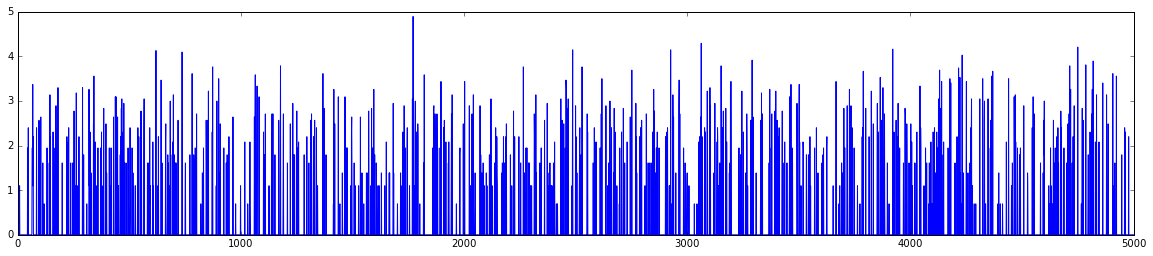

In [47]:
nval=5000
plt.plot(data['id'].head(nval).values,data['feature 203'].head(nval).values)

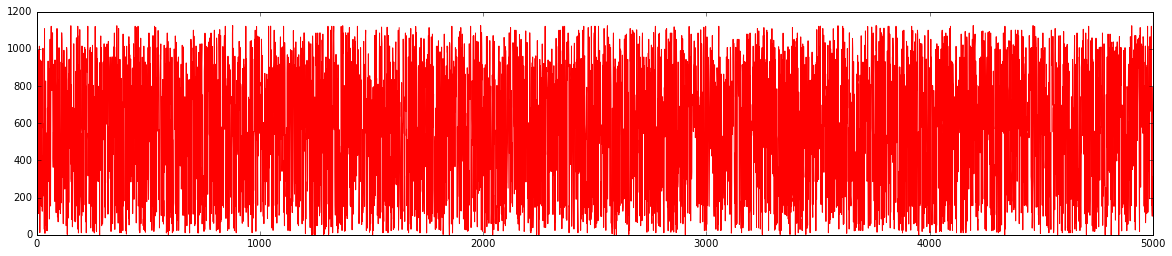

In [48]:
plt.plot(data['id'].head(nval).values,data['location'].head(nval).values,c='red')

In [49]:
# nval=500
# plt.plot(data['id'].head(nval).values,data['severity_type_combined'].head(nval).values)

In [50]:
# nval=1000
# plt.plot(data['id'].head(nval).values,data['fault_severity'].head(nval).values)

In [51]:
# data[['id','pattern_feature']]

In [52]:
# pd.crosstab(data['severity_type_combined'],data['fault_severity'])

In [53]:
# pd.crosstab(data['resource_type 8'],data['fault_severity'])

In [54]:
# pd.crosstab(data['pattern_all_similar'],data['fault_severity'])

In [55]:
# pd.crosstab(data['pattern_feature_similar'],data['fault_severity'])

## Divide back into test and train

In [56]:
train = data.loc[data['source']=='train']
test = data.loc[data['source']=='test']
train.drop('source',axis=1,inplace=True)
test.drop(['source','fault_severity'],axis=1,inplace=True)
train.to_csv('data/train_modified_9.csv',index=False)
test.to_csv('data/test_modified_9.csv',index=False)

/Users/aarshay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/aarshay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
